In [ ]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("BasicInterpolators")

# Resolvemos para atmósfera estratificada
Siendo $\vec{q}=\nabla(\tau)$ y $\vec{w}$ el vector velocidad del viento, para una atmósfera estratificada se obtiene $\dfrac{dq_x}{dt}=\dfrac{dq_y}{dt}=0;\dfrac{dq_z}{dt}=-q\dfrac{\partial c}{\partial z}-\vec{q}.\dfrac{\partial \vec{w}}{\partial z}$ (Brouwer 2014).

Implementamos un caso de velocidad del sonido dependiente de la altura con la temperatura: $c_{air}=331 \dfrac{m}{s}\sqrt{\dfrac{T_{z=0m}-\dfrac{z}{300m}}{273.15 K}}$ y un viento diagonal $\vec{w_{z=1m}}=(5,5)$ a 1 m de altura que varía con la altura siguiendo un modelo Logarítmico $\vec{w}=\vec{w_{z=1m}}(1+ln(\dfrac{z}{1m})) \hspace{0.5cm}if \hspace{0.1cm} z\geq 1 $ 


Obtenemos: $\dfrac{dq_z}{dt}=-\sqrt{q_x^2+q_y^2+q_z^2}\dfrac{\partial c}{\partial z}-\vec{q}.\dfrac{\partial \vec{w}}{\partial z}; \dfrac{\partial c}{\partial z}=-\dfrac{331}{600*273.15\sqrt{\dfrac{T_{z=0m}-\dfrac{z}{300m}}{273.15 K}}}=- \dfrac{331^2}{600*273.15*c(T,z)}\dfrac{1}{s}; \vec{q}.\dfrac{\partial \vec{w}}{\partial z}= \vec{q}\dfrac{w_{z=1m}}{z}= \dfrac{5(q_x+q_y)}{z}  \Rightarrow \dfrac{dq_z}{dt}=c(T,z)\dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}}{600*273.15*c(T,z)}- \dfrac{5(q_x+q_y)}{c(T,z)z} \Rightarrow \dfrac{dq_z}{dz}=\dfrac{\sqrt{q_{x}^2+q_{y}^2+q_z^2}}{600*(T_{z=0m}-2z)}-\dfrac{5(q_x+q_y)q_z}{c(T,z)z}$

$\dfrac{dq_z}{dz}=\dfrac{\sqrt{q_{x}^2+q_{y}^2+q_z^2}}{600*T_{z=0m}-2z}-\dfrac{5(q_x+q_y)q_z}{c(T,z)z}$

Con $\dfrac{dt}{d\tau}=1$ y la c.i. $\tau(x,y,z=Source)=0$ obtenemos $\tau=| \int \vec{q} d \vec{s} | \approx \Sigma |\vec{q_i}.\vec{\Delta {s_i}}  |  $ siendo s cada elemento diferencial de la trayectoria recorrida por el rayo acústico.

In [1]:
function v_wind_LogLaw(v_wind,z)
    v_wind_X=v_wind[1]*(1+log(z))
    v_wind_Y=v_wind[2]*(1+log(z))
    return v_wind_X, v_wind_Y
end
function c_air_TZ(T_z0,z)
    c_air=331*sqrt((T_z0+273.15-z/300)/273.15) #Introduzco T_Z0 en grados centígrados por comodidad
    return c_air
end

c_air_TZ (generic function with 1 method)

Resolvemos la ODE: $\dfrac{dq_x}{dx}=\dfrac{dq_y}{dy}=0 ; \dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}-\dfrac{5(q_x+q_y)q_z}{z}$

In [2]:
@time begin
using DifferentialEquations
T=15.;
v_wind=[5.,5.,0.];

SourcePoint=[1.,1.,1.];
#El modelo logarítmico de viento es razonable hasta altitudes no muy grandes.
ReceiverPoint=[5001.,5001.,501.];

#Definimos la ODE 
    function q!(dq, q, p, z)
        c=c_air_TZ(p[1],z)
        dq[1]=0
        dq[2]=0
        dq[3] = 331^2*sqrt(q[1]^2 + q[2]^2 + q[3]^2)*q[3] / (600 * 273.15 *c) - 5*(q[1]+q[2])*q[3]/z
    end
    theta=rad2deg(acos(500/sqrt(2*5000^2+500^2)))
    phi=45 #Calculados directamente
    # Definimos las condiciones iniciales y los parámetros
    q0=1/(c_air_TZ(T, SourcePoint[3])+(v_wind[1]*cosd(phi)+v_wind[2]*sind(phi))*sind(theta))
    q_x = q0*cosd(phi)*sind(theta)
    q_y = q0*sind(phi)*sind(theta)
    q_z = q0*cosd(theta)
    u0 = [q_x, q_y, q_z]
    

    # Definimps el rango de valores de z. Debemos tener cuidado al optimizar, dado
    # que si algún valor (coordenada z) optimizado está fuera de zspan no podemos evaluarlo.
    zspan = (SourcePoint[3], ReceiverPoint[3])

    # Definimos los parámetros
    p = [T] 

    # Definir el problema ODE
    prob = ODEProblem(q!, u0, zspan, p)
    
    #Resolvemos el problema ODE almacenando en los valores de Z que se corresponden a las uniones de los segmentos.
    #z_values=SegmentsCoords[:,3]
    #, saveat=z_values
    sol = solve(prob, RK4(),dt=1e-3)
    #Mirar documentacion para obtener funcion e introducirla como argumento de entrada
    
    #Guardamos los valores de vec(q)
    qx_vals=zeros(length(sol.u))
    qy_vals=zeros(length(sol.u))
    qz_vals=zeros(length(sol.u))

    for i in 1:length(sol.u)
        qx_vals[i]=sol.u[i][1]
        qy_vals[i]=sol.u[i][2]
        qz_vals[i]=sol.u[i][3]
    end
#########################
end

 29.804555 seconds (24.28 M allocations: 1.703 GiB, 3.83% gc time, 10.15% compilation time: 2% of which was recompilation)


In [3]:
using Interpolations
###### qx y qy son constantes
qx=sum(qx_vals)/length(qx_vals)
######
qy=sum(qy_vals)/length(qy_vals)
######
#Interpolamos para obtener qz(z) en todo punto entre la fuente y el receptor
z_values_cubic = range(SourcePoint[3], stop=ReceiverPoint[3], length=length(qz_vals))
qz_z_cubic=CubicSplineInterpolation(z_values_cubic, qz_vals);




In [4]:
using DifferentialEquations

function Hamiltonian_c(qx::Float64,qy::Float64,qz_z_cubic, SegmentsCoords::Array{Float64, 2})
   
    #Calculamos los traveltime entre cada segmento tomando la media de las q entre cada segmento (aproximación regla Trapecio)
    taus=zeros(length(SegmentsCoords[:,1])-1)
    for i in 1:(length(SegmentsCoords[:,1])-1)
        #qx y qy son constantes, da igual que elemento del vector cojamos. Solo debemos tener cuidado con
        aux_x=(SegmentsCoords[i+1,1]-SegmentsCoords[i,1])
        aux_y=(SegmentsCoords[i+1,2]-SegmentsCoords[i,2])
        # La función de interpolación cúbica puede extrapolarse ligeramente fuera del rango de los datos
        #debido a la naturaleza de la interpolación cúbica.  Iterando la condición inicial lleva a BoundsError. Debo emplear 
        #clamp() para asegurarme que interpola dentro del rango
        z1 = clamp(SegmentsCoords[i,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        z2 = clamp(SegmentsCoords[i+1,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        aux_z=(SegmentsCoords[i+1,3]-SegmentsCoords[i,3])
        q_m=sqrt(qx^2+qy^2+(qz_z_cubic(z1)+qz_z_cubic(z2))^2/4)
        taus[i]=q_m*sqrt(aux_x^2+aux_y^2+aux_z^2)
    end
    
    #Sumamos el travel time de cada segmento para obtener el total
    total_travel_time = sum(taus)
        
    return total_travel_time
end

Hamiltonian_c (generic function with 1 method)

# Nota

Vemos que qz disminuye bastante a medida que aumenta la altura. Es razonable que el optimizador concentre entonces la mayor cantidad de puntos alrededor del receptor. Esto no es realista para la representación de una curva. Por tanto, se impondrá una penalización si los puntos no están equiespaciados.

In [11]:
@time begin
using Optim
using Statistics
    
#Optimizamos las coordenadas de las uniones entre segmentos
function objective(SegmentsCoords)
    # Primero nos aseguramos de que SourcePoint y ReceiverPoint no se optimizan pero que se incluyen en SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_c(qx, qy, qz_z_cubic, FullSegmentsCoords)

    # Calculamos las distancias entre segmentos consecutivos
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # Calculamos la desviación estándar de las distancias
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # Agregamos una penalización a la función objetivo basada en la desviación estándar de las distancias
    return traveltime + distance_std_normalized
end


#Recta troceada desde la fuente al receptor como condición inicial
num_segments=10;
initial_SegmentsCoords = zeros(num_segments-1, 3); 
for i in 1:num_segments-1
    alpha = i / num_segments
    initial_SegmentsCoords[i, :] = SourcePoint + alpha * (ReceiverPoint - SourcePoint) 
end
#Restringimos a X,Y estar entre 0 y 2000m por si el optimizador realiza la curva exteriormente.
#A Z se restringe estar entre la fuente y el receptor para que no haya problema con el intervalo de resolución de la ODE.
lower_bounds = fill(SourcePoint[1], size(initial_SegmentsCoords))
upper_bounds = fill(ReceiverPoint[1], size(initial_SegmentsCoords))
lower_bounds[:, 3] .= 0.
upper_bounds[:, 3] .= 1001.


# Optimizador interno. Limited-memory Broyden-Fletcher-Goldfarb-Shanno
#método de optimización de segundo orden valido para minimizar funciones no lineales.
inner_optimizer = LBFGS()

# Optimizador con las restricciones "de caja"
optimizer_with_constraints = Fminbox(inner_optimizer)

# Optimizamos con las restricciones
result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)

#Resultado de la optimización
Optimal_SegmentsCoords = result.minimizer;
    
#Incluimos la fuente y el receptor a las coordenadas optimizadas
Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
    
#Evaluamos el traveltime para la trayectoria optimizada
traveltime =Hamiltonian_c(qx, qy, qz_z_cubic, Full_Optimal_SegmentsCoords)
println("The total travel time for the segmented trajectory is: ", traveltime, " seconds")
end

println("Iteraciones realizadas: ", result.iterations)
println("Evaluaciones de la función: ", result.f_calls)



The total travel time for the segmented trajectory is: 20.422414417482724 seconds
  0.555365 seconds (1.80 M allocations: 134.125 MiB, 19.65% gc time, 32.37% compilation time: 100% of which was recompilation)
Iteraciones realizadas: 2
Evaluaciones de la función: 1752


In [12]:
Full_Optimal_SegmentsCoords

11×3 Matrix{Float64}:
    1.0       1.0      1.0
  500.887   500.887   53.2959
 1000.8    1000.8    105.418
 1500.74   1500.74   157.033
 2000.68   2000.68   208.032
 2500.67   2500.67   258.391
 3000.69   3000.69   308.112
 3500.74   3500.74   357.21
 4000.82   4000.82   405.707
 4500.92   4500.92   453.63
 5001.0    5001.0    501.0

In [13]:
@time begin
using Optim
using Statistics
#Argumentos y datos

#Optimizamos las coordenadas de las uniones entre segmentos
function objective(SegmentsCoords)
    # Primero nos aseguramos de que SourcePoint y ReceiverPoint no se optimizan pero que se incluyen en SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_c(qx, qy, qz_z_cubic, FullSegmentsCoords)

    # Calculamos las distancias entre segmentos consecutivos
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # Calculamos la desviación estándar de las distancias
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # Agregamos una penalización a la función objetivo basada en la desviación estándar de las distancias
    return traveltime + distance_std_normalized
end

#Definimos una matriz de matrices Plot_Coords del tamaño del bucle o mayor para luego graficar la distancia de los puntos a una recta
Plot_Coords = Matrix{Matrix{Float64}}(undef, 10, 1)

#Iteramos la condición inicial
initial_SegmentsCoords = zeros(1, 3); #c.i.
for i in 1:6
    if i == 1
        initial_SegmentsCoords[1, :] = SourcePoint + (ReceiverPoint - SourcePoint) / 2
    end
        
    #Restringimos a X,Y estar entre 0 y 2000m por si el optimizador realiza la curva exteriormente.
    #A Z se restringe estar entre la fuente y el receptor para que no haya problema con el intervalo de resolución de la ODE.
    lower_bounds = fill(0., size(initial_SegmentsCoords))
    upper_bounds = fill(6000., size(initial_SegmentsCoords))
    lower_bounds[:, 3] .= 0.
    upper_bounds[:, 3] .= 1000.

    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
        
    #Almacenamos las coordenadas de la optimización incluyendo la fuente y el receptor para luego graficar
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    
    #Evaluamos el travel time para los distintos números de segmentos planteados
    total_time = Hamiltonian_c(qx, qy, qz_z_cubic, Full_Optimal_SegmentsCoords)
    println("Num segments: ", Int(size(Full_Optimal_SegmentsCoords, 1) - 1), ". Traveltime:", total_time, " s")
    println("Iteraciones realizadas: ", result.iterations, ". Evaluaciones de la función: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 3)
    
    # Calculamos copy_optimal_SegmentsCoords 
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(SourcePoint+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+ReceiverPoint)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
    #Aquí iteramos la condición inicial
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
end
end




Num segments: 2. Traveltime:20.422166899452765 s
Iteraciones realizadas: 2. Evaluaciones de la función: 38
Num segments: 4. Traveltime:20.422353964672563 s
Iteraciones realizadas: 1. Evaluaciones de la función: 74
Num segments: 8. Traveltime:20.422411788947883 s
Iteraciones realizadas: 1. Evaluaciones de la función: 735
Num segments: 16. Traveltime:20.422414321460064 s
Iteraciones realizadas: 2. Evaluaciones de la función: 2479
Num segments: 32. Traveltime:20.42241587827463 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1207
Num segments: 64. Traveltime:20.422416260634776 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1380
  7.015593 seconds (17.77 M allocations: 3.683 GiB, 11.68% gc time, 2.55% compilation time: 100% of which was recompilation)


In [14]:
using Plots 

# Definimos los nombres de las etiquetas y las formas para cada número de segmentos
labels = ["2 segments", "4 segments", "8 segments", "16 segments", "32 segments", "64 segments", "128 segments", "256 segments", "512 segments"]
shapes = [:diamond, :square, :star6, :octagon, :circle, :star4, :star5, :octagon, :circle]

plot(legend=:topleft)

# Iteramos sobre cada conjunto de coordenadas de segmentos
for i in 1:6
    z = Plot_Coords[i][:, 3]
    aux = sqrt.((Plot_Coords[i][:, 1]/10-Plot_Coords[i][:, 3]).^2+(Plot_Coords[i][:, 2]/10-Plot_Coords[i][:, 3]).^2)
    aux[1] = aux[end] = 0.
    plot!(z, aux, label=labels[i], shape=shapes[i])
end

xlabel!("z (m)")
ylabel!("Deviation to a straight line (m)")
#savefig("TrayectoriaWvarSpatialGradient.png")

"C:\\Users\\Miguel\\Desktop\\TFM\\Codigos Julia\\TrayectoriaWvarSpatialGradient.png"

In [9]:
Plot_Coords[4] #16 segmentos

17×3 Matrix{Float64}:
    1.0       1.0      1.0
  313.436   313.436   33.7333
  625.902   625.902   66.4646
  938.366   938.366   99.0613
 1250.83   1250.83   131.461
 1563.3    1563.3    163.628
 1875.77   1875.77   195.543
 2188.26   2188.26   227.201
 2500.76   2500.76   258.601
 2813.26   2813.26   289.745
 3125.77   3125.77   320.635
 3438.29   3438.29   351.277
 3750.82   3750.82   381.677
 4063.36   4063.36   411.84
 4375.9    4375.9    441.773
 4688.46   4688.46   471.491
 5001.0    5001.0    501.0

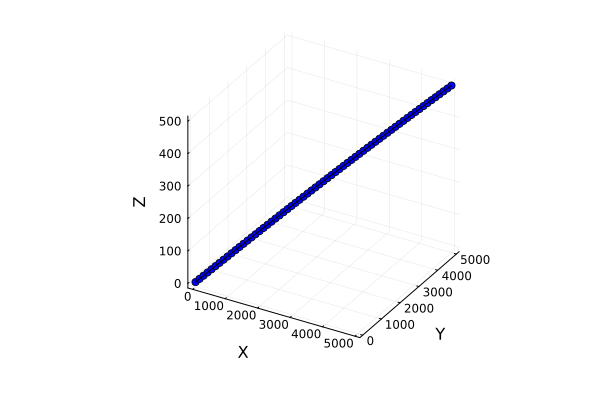

In [10]:
using Plots
plot()

x_coords = Plot_Coords[6][:, 1]
y_coords = Plot_Coords[6][:, 2]
z_coords = Plot_Coords[6][:, 3]

scatter!(x_coords, y_coords, z_coords, marker=:circle, color=:blue, legend=false)
for i in 1:length(x_coords)-1
    plot!([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]], [z_coords[i], z_coords[i+1]], color=:black, linewidth=1)
end

xlabel!("X")
ylabel!("Y")
zlabel!("Z")